In [1]:
import re
import pandas as pd
import numpy as np
import json
import subprocess
import glob
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib import cm
matplotlib.style.use('ggplot')
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

In [2]:
N_SEEDS = 8
N_SEI = 20
N_TESTS = 5
N_TICKS = 260
N_TICKS_DISPLAY = 260 - 52
N_TICKS_BURN = N_TICKS - N_TICKS_DISPLAY

In [3]:
def read_error_data_from_log(file, data_):
    regex_error_savings = re.compile('(INFO:\sNEGATIVE\sSAVINGS\s*)')
    regex_error_small_system = re.compile('(INFO:\sSMALL\sSYSTEM\s*)')
    N_SMALL_SAVINGS = 0
    N_SMALL_SYSTEMS = 0
    
    with open(file) as infile:
        for line in infile:
            if regex_error_savings.search(line):
                res = re.split(regex_error_savings, line)
                N_SMALL_SAVINGS = N_SMALL_SAVINGS + 1
            elif regex_error_small_system.search(line):
                res = re.split(regex_error_small_system, line)
                N_SMALL_SYSTEMS = N_SMALL_SYSTEMS + 1
            else:
                pass
            
    
    return (N_SMALL_SAVINGS, N_SMALL_SYSTEMS)

In [10]:
#Reads data from the given file into the given list
def read_data_from_log(file, data_):
    regex_begin_tick = re.compile('(N\s*active\s*agents\s*at\s*tick\s*)')
    regex_end_tick = re.compile('(Number\s*of\s*installed\s*projects\s*:\s*)')
    regex_data =  re.compile('(INFO:\s)')
    regex_data_check = re.compile('EParamTypes')
    regex_enum = re.compile('(::[\w]*\s*:\s*)')
    regex_enum_name = re.compile('([^:\s]+)')
    regex_1 = re.compile('(\s*:\s*)')
    
    
    with open(file) as infile:
        for line in infile:
            if regex_begin_tick.search(line):
                #parse tick number 
                #start new dictionary in the list
                data_.append({})

                #get tick 
                res = re.split(regex_1, re.split(regex_begin_tick, line)[-1])
                data_[-1]['N_AGENTS'] = float(res[-1])
                data_[-1]['tick'] = float(res[0])
            elif regex_end_tick.search(line):
                res = re.split(regex_end_tick, line)
                data_[-1]['N_PROJECTS'] = float(res[-1])
            else:
                if (regex_data.search(line)) and (regex_data_check.search(line)):
                    res = re.split(regex_data, line)
                    #get last part and enum name 
                    #last part is number
                    res2 = re.split(regex_enum, res[-1])
                    #get enum name 
                    data_[-1]['EParamTypes::' + re.split(regex_enum_name, res2[-2])[-2]] = float(res2[-1])
#    print(data_)

In [11]:
def get_subset_data(data_):
    #data_column_names
    data_columns = {'EParamTypes::HOStateDroppedOutNCDecStage':[],\
                   'EParamTypes::HOStateDroppedOutSEIStage':[],\
                   'EParamTypes::HOStateDroppedOutDesignStage':[],\
                    'EParamTypes::HOStateDroppedOutTickNCDecStage':[],\
                    'EParamTypes::HOStateDroppedOutTickSEIStage':[],\
                    'EParamTypes::HOStateDroppedOutTickDesignStage':[],\
                   'EParamTypes::HONumberActiveAgents':[]}
    tick = []
    i = 0
    #collect data for each tick 
    for row in data_:
        for key, value in data_columns.items():
            value.append(0.0)
            if key in row:
                value[-1] = row[key]
        tick.append(i)
        i = i + 1
    
    return data_columns

#print(data_columns)

In [12]:
#N_tests - number of different tests that were run 
#dfs_logs - where to save them
def collect_data_for_simulation_runs_from_logs(N_TESTS, dfs_logs):


    test_mode = 'BaseModel'
    test_version = 'BaseVer02'
    test_loc = 'CA'
    data_mode = 'Logs'
    version = '_eff'
    params_versions = [str(x) for x in np.linspace(-0.5,1.5,N_TESTS,endpoint=True)]
    

    for i_run in range(N_TESTS):  

        #get latest file 
        files = glob.glob('..\\..\\ABMIRISLab\\Saves\\May-14-2018\\' + test_mode + '\\' + test_version + '\\'  +\
                          test_loc + '\\permit' + params_versions[i_run] + '\\' + data_mode +\
                         '\\*[_log].log')
        files.sort(key=os.path.getmtime, reverse=True)
        files_ = files[0 * N_SEEDS : 1 * N_SEEDS]    

        dfs_ = []

        for file in files_:

            #if find N active agents at tick
            # start data for the tick 
            #parse data - name of the enum, value
            data_ = []
            read_data_from_log(file, data_)
            data_subset_ = get_subset_data(data_)
            df_ = pd.DataFrame(
                data_subset_
                )
            df_.index.name = 'tick'

            dfs_.append(df_)





        #get averages 
        #create df from them    
        df_concat = pd.concat(dfs_)
        df_logs = df_concat.groupby(level=0).mean()


        dfs_logs.append(df_logs)

In [13]:
dfs_logs = []
collect_data_for_simulation_runs_from_logs(N_TESTS, dfs_logs)
df_logs = dfs_logs[0]

In [14]:
dfs_logs[0].head()

,EParamTypes::HONumberActiveAgents,EParamTypes::HOStateDroppedOutDesignStage,EParamTypes::HOStateDroppedOutNCDecStage,EParamTypes::HOStateDroppedOutSEIStage,EParamTypes::HOStateDroppedOutTickDesignStage,EParamTypes::HOStateDroppedOutTickNCDecStage,EParamTypes::HOStateDroppedOutTickSEIStage
tick,,,,,,,
0,59.142857,0.0,0.0,0.0,0.0,0.0,0.0
1,108.142857,0.0,0.0,0.0,0.0,0.0,0.0
2,157.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,205.428571,0.0,0.0,0.0,0.0,0.0,0.0
4,254.142857,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
def collect_data_for_simulation_runs_from_w(N_TESTS, dfs_w, dfs_w_std):

    test_mode = 'BaseVer02'
    data_mode = 'CA'
    #here think how to change it
    params_versions = [str(x) for x in np.linspace(-0.5,1.5,N_TESTS,endpoint=True)]

    #names of columns in a file
    names = ['N_installed', 'N_installed_sum', 'P_av_total', 'P_av']
    for i in range(N_SEI):
        names.append('sei_markup_' + str(i))



    for i_run in range(N_TESTS): 
        #read few files
        #save into database
        dfs_ = []
        #read last simulation result
        files = glob.glob('..\\..\\ABMIRISLab\\Saves\\May-14-2018\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                         '\\permit' + params_versions[i_run] + '\\*[_w].csv')
        files.sort(key=os.path.getmtime, reverse=True)

        #take top x files 
        for file in files[0 * N_SEEDS : 1 * N_SEEDS]:
            df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
            dfs_.append(df_)


        #create df from them    
        df_concat = pd.concat(dfs_)
        df_w_mean = df_concat.groupby(level=0).mean()
        df_w_std = df_concat.groupby(level=0).std()
        
        dfs_w.append(df_w_mean)
        dfs_w_std.append(df_w_std)

In [16]:
dfs_w = []
dfs_w_std = []
collect_data_for_simulation_runs_from_w(N_TESTS, dfs_w, dfs_w_std)

In [17]:
dfs_w[0].head()

,N_installed,N_installed_sum,P_av_total,P_av,sei_markup_0,sei_markup_1,sei_markup_2,sei_markup_3,sei_markup_4,sei_markup_5,...,sei_markup_10,sei_markup_11,sei_markup_12,sei_markup_13,sei_markup_14,sei_markup_15,sei_markup_16,sei_markup_17,sei_markup_18,sei_markup_19
0,0.0,0.0,0.0,0.0,0.491332,0.686154,0.394593,0.537956,0.544454,0.551717,...,0.447666,0.552777,0.392875,0.445332,0.453472,0.515118,0.527037,0.419609,0.507716,0.48574
1,0.0,0.0,NaN,NaN,0.491332,0.686154,0.394593,0.537956,0.544454,0.551717,...,0.447666,0.552777,0.392875,0.445332,0.453472,0.515118,0.527037,0.419609,0.507716,0.48574
2,0.0,0.0,NaN,NaN,0.491332,0.686154,0.394593,0.537956,0.544454,0.551717,...,0.447666,0.552777,0.392875,0.445332,0.453472,0.515118,0.527037,0.419609,0.507716,0.48574
3,0.0,0.0,NaN,NaN,0.491332,0.686154,0.394593,0.537956,0.544454,0.551717,...,0.447666,0.552777,0.392875,0.445332,0.453472,0.515118,0.527037,0.419609,0.507716,0.48574
4,0.0,0.0,NaN,NaN,0.491332,0.686154,0.394593,0.537956,0.544454,0.551717,...,0.447666,0.552777,0.392875,0.445332,0.453472,0.515118,0.527037,0.419609,0.507716,0.48574


In [18]:
dfs_w_std[0].head()

,N_installed,N_installed_sum,P_av_total,P_av,sei_markup_0,sei_markup_1,sei_markup_2,sei_markup_3,sei_markup_4,sei_markup_5,...,sei_markup_10,sei_markup_11,sei_markup_12,sei_markup_13,sei_markup_14,sei_markup_15,sei_markup_16,sei_markup_17,sei_markup_18,sei_markup_19
0,0.0,0.0,0.0,0.0,0.1851,0.261796,0.17364,0.240288,0.294364,0.226905,...,0.246397,0.304951,0.188979,0.201515,0.214049,0.195579,0.194259,0.185985,0.226806,0.158702
1,0.0,0.0,NaN,NaN,0.1851,0.261796,0.17364,0.240288,0.294364,0.226905,...,0.246397,0.304951,0.188979,0.201515,0.214049,0.195579,0.194259,0.185985,0.226806,0.158702
2,0.0,0.0,NaN,NaN,0.1851,0.261796,0.17364,0.240288,0.294364,0.226905,...,0.246397,0.304951,0.188979,0.201515,0.214049,0.195579,0.194259,0.185985,0.226806,0.158702
3,0.0,0.0,NaN,NaN,0.1851,0.261796,0.17364,0.240288,0.294364,0.226905,...,0.246397,0.304951,0.188979,0.201515,0.214049,0.195579,0.194259,0.185985,0.226806,0.158702
4,0.0,0.0,NaN,NaN,0.1851,0.261796,0.17364,0.240288,0.294364,0.226905,...,0.246397,0.304951,0.188979,0.201515,0.214049,0.195579,0.194259,0.185985,0.226806,0.158702


In [19]:
colors_ = ['orange', 'olive', 'olive','olive', 'lightcyan'] 
colors_ = ['orange', 'red', 'yellow','green', 'lightcyan'] 

In [20]:
dfs_logs[-1]['SumEParamTypes::HOStateDroppedOutTickNCDecStage'] = dfs_logs[-1]['EParamTypes::HOStateDroppedOutTickNCDecStage'].cumsum()
dfs_logs[-1]['SumEParamTypes::HOStateDroppedOutTickSEIStage'] = dfs_logs[-1]['EParamTypes::HOStateDroppedOutTickSEIStage'].cumsum()
dfs_logs[-1]['SumEParamTypes::HOStateDroppedOutTickDesignStage'] = dfs_logs[-1]['EParamTypes::HOStateDroppedOutTickDesignStage'].cumsum()

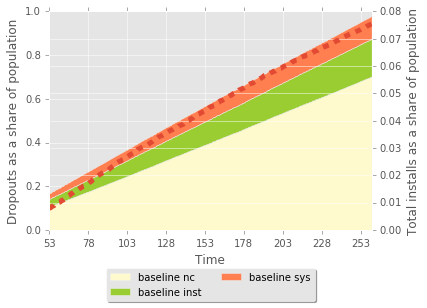

In [21]:
#number of dropouts as stacked bars
data_mode = 'permit_bm_'
test_mode = 'drops'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#reverse order of simulations
#df_logs = dfs_logs[-1]

#if ncols = 1  - transform into list
par1 = axes_.twinx()
axes = [axes_, par1]

#baseline
df_logs = dfs_logs[-1]

#axes_0_tw = axes[0].twinx()

ind = np.arange(N_TICKS)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

ind = df_logs.index.values[N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY] + 1

lines = []
i = 0

markers = ["ro", "r^", "r*"]
markerfacecolors = colors_
colors_l = ['r', 'r', 'r']
labels_raw = ["nc", "inst", "sys"]
labels = ['baseline ' + x for x in labels_raw]
data_ = []
markers_ = []
labels_ = []
colors_graph_ = []
data_columns = ['SumEParamTypes::HOStateDroppedOutTickNCDecStage',\
                   'SumEParamTypes::HOStateDroppedOutTickSEIStage',\
                   'SumEParamTypes::HOStateDroppedOutTickDesignStage',\
                   'EParamTypes::HONumberActiveAgents']

for column in data_columns[0:3]:
    data_.append(df_logs[column][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000)
    markers_.append(markers[i])
    labels_.append(labels[i])
    colors_graph_.append(colors_[i])

    i = i + 1
    
pi = axes[0].stackplot(ind, data_, colors=tuple(['lemonchiffon', 'yellowgreen', 'coral']), labels=tuple(labels_))
    


for pi_ in pi:
    lines.append(pi_)

    
markers = ["go", "g^", "g*"]
colors_l = ['g', 'g', 'g']
labels = ['high ef ' + x for x in labels_raw]

   

axes[0].set_xlabel("Time")
axes[0].set_ylabel("Dropouts as a share of population")


#axes[0].set_autoscaley_on(False)
axes[0].set_xlim([N_TICKS_BURN +1,N_TICKS_BURN +N_TICKS_DISPLAY])
#axes_0_tw.set_ylim([0.0, 5.0])
start = N_TICKS_BURN +1
end = N_TICKS_BURN +N_TICKS_DISPLAY
axes[0].xaxis.set_ticks(np.arange(start, end, 25))




# Shrink current axis's height by 10% on the bottom
box = axes[0].get_position()
axes[0].set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height * 0.8])

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=True, shadow=True, fontsize='10', ncol = 2)


markers = ["o-", "--", "--", "--", "*-"]
markerfacecolors = colors_
colors_l = ['r', 'r', 'r']
labels = ['tariff ' + str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=True)]

#number of installs
pi, = axes[1].plot(ind, dfs_w[-1]['N_installed_sum'][N_TICKS_BURN:N_TICKS_BURN + N_TICKS_DISPLAY]/10000, markers[1], linewidth=5)

axes[1].set_ylabel("Total installs as a share of population")


plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_May22' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [22]:
print(len(dfs_logs))
print(N_TESTS)

5
5


In [23]:
dfs_w[0]['N_installed_sum'].values[N_TICKS_BURN +N_TICKS_DISPLAY]

715.25

In [24]:
data_columns = ['EParamTypes::HOStateDroppedOutNCDecStage',\
                   'EParamTypes::HOStateDroppedOutSEIStage',\
                   'EParamTypes::HOStateDroppedOutDesignStage']

data_drops = []
column_i = 0
for column in data_columns[0:3]:
    data_drops.append([])

    for i in range(N_TESTS):
        #print(dfs_logs[i][column][N_TICKS_BURN+N_TICKS_DISPLAY-1:N_TICKS_BURN +N_TICKS_DISPLAY].values[-1])
        data_drops[column_i].append(dfs_logs[i][column][N_TICKS_BURN+N_TICKS_DISPLAY-1:N_TICKS_BURN +N_TICKS_DISPLAY].values[-1]\
                                    /dfs_w[i]['N_installed_sum'].values[N_TICKS_BURN +N_TICKS_DISPLAY])
    column_i = column_i + 1     


In [25]:
print(data_drops)

[[5.6459779297947765, 5.4438664205403589, 5.6723146823304971, 5.541782661782662, 5.3194942441970179], [1.3054376591601338, 1.2556277419509505, 1.3378517458643973, 1.2721855921855922, 1.2464615965276467], [0.74299695411194888, 0.70232301680531239, 0.74182292843336595, 0.71931623931623934, 0.70673712021136059]]


In [26]:
data_drops_acc = [[data_drops[0][i] for i in range(N_TESTS)]]
print(data_drops_acc)
        

[[5.6459779297947765, 5.4438664205403589, 5.6723146823304971, 5.541782661782662, 5.3194942441970179]]


In [27]:
for i in range(1, len(data_drops), 1):
    data_drops_acc.append([])
    #print(data_drops_acc)
    for j in range(0, N_TESTS, 1):
        data_drops_acc[i].append(data_drops_acc[i-1][j] + data_drops[i][j])
        
print(data_drops_acc)

[[5.6459779297947765, 5.4438664205403589, 5.6723146823304971, 5.541782661782662, 5.3194942441970179], [6.9514155889549105, 6.6994941624913089, 7.0101664281948946, 6.8139682539682545, 6.5659558407246648], [7.6944125430668597, 7.4018171792966214, 7.7519893566282603, 7.5332844932844942, 7.2726929609360251]]


In [28]:
for i in range(len(data_drops[0])):
    print(data_drops[1][i]/data_drops[0][i])

0.231215508702
0.230649991193
0.235856404447
0.229562519829
0.234319568611


In [29]:
for i in range(len(data_drops[0])):
    print(data_drops[2][i]/data_drops[0][i])

0.131597566153
0.129011802008
0.130779579409
0.129798709768
0.132857953739


In [30]:
len(data_columns)

3

[6.9514155889549105, 6.6994941624913089, 7.0101664281948946, 6.8139682539682545, 6.5659558407246648]
[5.6459779297947765, 5.4438664205403589, 5.6723146823304971, 5.541782661782662, 5.3194942441970179]
[7.6944125430668597, 7.4018171792966214, 7.7519893566282603, 7.5332844932844942, 7.2726929609360251]
[6.9514155889549105, 6.6994941624913089, 7.0101664281948946, 6.8139682539682545, 6.5659558407246648]


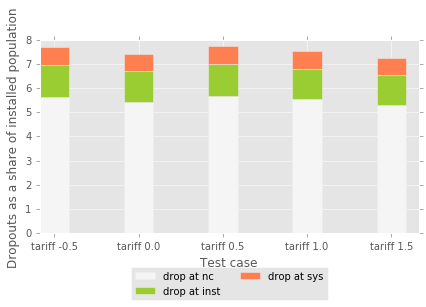

In [31]:
#number of dropouts as stacked bars
data_mode = 'permit_bm_'
test_mode = 'drops_all_tariff'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#if ncols = 1  - transform into list
axes = [axes_]

ind = np.arange(len(dfs_logs))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


colors_drops = tuple(['whitesmoke', 'yellowgreen', 'coral'])

#N_TESTS = len(dfs_logs)
labels_raw = ["nc", "inst", "sys"]
labels_hist = ['drop at ' + x for x in labels_raw]

p1 = axes[0].bar(ind[0:N_TESTS], data_drops_acc[0][0:N_TESTS],\
                 width, color=colors_drops[0], label = labels_hist[0])
lines = [p1]



for bin_ in range(1, len(data_columns), 1):
    print(data_drops_acc[bin_][0:N_TESTS])
    print(data_drops_acc[bin_ - 1][0:N_TESTS])
    p2 = axes[0].bar(ind[0:N_TESTS], \
                     data_drops[bin_][0:N_TESTS], \
                     width, color=colors_drops[bin_], \
                  bottom=data_drops_acc[bin_ - 1][0:N_TESTS], label = labels_hist[bin_])
    lines.append(p2)
    
axes[0].set_xlabel("Test case")
axes[0].set_ylabel("Dropouts as a share of installed population")
#axes[0].set_title('Accumulated % installations \n by the level \n of income', fontsize=10)


axes[0].set_xticks(ind[0:N_TESTS] + width / 2)
axes[0].set_xticklabels(ind[0:N_TESTS])
labels = ['tariff ' + str(x) for x in np.linspace(-0.5,1.5,N_TESTS,endpoint=True)]
x_labels = labels
axes[0].set_xticklabels(x_labels)

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=False, shadow=False, fontsize='10', ncol = 2)



plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_May22' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [52]:
print(ind)

[0 1 2 3]


In [ ]:
#penetration by income group in time?
#penetration by el bill in time? 



In [121]:
#location x, location y 


# for each line - place into location
# average over locations
#
#

N_TILES = 10
N_SEEDS = 8

test_mode = 'BaseVer02'
data_mode = 'CA'

#names of columns in a file
names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Mart_type']

raw_data_per_tick = []
raw_data_dfs_per_tick = []
tick_bins = []
for i in range(4):
    #to store final results
    raw_data_per_tick.append(np.zeros((N_TILES, N_TILES)))
    #to store intermediate results
    raw_data_dfs_per_tick.append(np.zeros((N_SEEDS, N_TILES, N_TILES)))
    #tick edges
    tick_bins.append(N_TICKS/4 *(i))


#here only baseline scenario is analyzed    
params_versions = [str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=False)]
    
#read few files
#save into database
dfs_ = []
#read last simulation result
files = glob.glob('..\\..\\ABMIRISLab\\Saves\\Jan-11-2018\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                 '\\tariff' + str(0.3) + '\\*[_pr].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top x files, assume only one type of a simulation run in a folder 
i_run = 0

for file in files[i_run * N_SEEDS : (i_run + 1) * N_SEEDS]:
    print(file)
    df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
    dfs_.append(df_)

    
raw_data_dfs = np.zeros((len(dfs_), N_TILES, N_TILES))

indexes = [0.0, 0.0, 0.0, 0.0]

k = 0
for df_ in dfs_:
    
    
    
    for i in range(N_TILES):
        for j in range(N_TILES):
            index = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j)].index 
                             
            indexes[0] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[0])].index
            
            indexes[1] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[1])].index
            
            indexes[2] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[2])].index
                             
            raw_data_dfs_per_tick[0][k, i, j] = df_.iloc[indexes[0]].shape[0]
            raw_data_dfs_per_tick[1][k, i, j] = df_.iloc[indexes[1]].shape[0]
            raw_data_dfs_per_tick[2][k, i, j] = df_.iloc[indexes[2]].shape[0]
            raw_data_dfs_per_tick[-1][k, i, j] = df_.iloc[index].shape[0]
            
    k = k + 1
    
    raw_data_per_tick[0] = np.mean(raw_data_dfs_per_tick[0], axis = 0)
    raw_data_per_tick[1] = np.mean(raw_data_dfs_per_tick[1], axis = 0)
    raw_data_per_tick[2] = np.mean(raw_data_dfs_per_tick[2], axis = 0)
    raw_data_per_tick[-1] = np.mean(raw_data_dfs_per_tick[-1], axis = 0)
    
    
#create df from them    
dfs_inst = dfs_

#blank first step
raw_data_per_tick[0] = np.zeros((N_TILES, N_TILES)) + 0.01

..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\37ed7bcf-e806-4fe2-b2bd-2b652ec7bcfd_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\29656eab-e4f9-4d65-92c2-d4bad48df315_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\5ca7a082-1cb0-448c-8278-36425f94ad49_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\c7b012ba-3ad5-40cc-81b1-2d92ba81cae8_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\20cf97d0-c313-4815-b0e7-8a952ec0ca19_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\1c784f8d-59fd-42ee-8b26-6c2e8c0d8558_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\3aab8956-253b-4ccb-8a0d-9ba92eee7158_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\f3cbc1de-38ce-4ac5-b4f0-7f193f542927_pr.csv


In [122]:
dfs_inst[-1].head(5)

,Tick,Location_x,Location_y,Uid,Price_per_watt,DC_size,Mart_type
0,37,9,2,43,2.8,2749.75,0
1,55,8,1,51,2.8,1820.13,0
2,45,4,5,55,2.8,3920.07,0
3,54,6,7,44,2.8,7000.12,0
4,55,8,2,40,2.8,4674.57,0


In [102]:
#define min and max installs
max_installs = np.amax(raw_data_per_tick[3])
min_installs = 0 

In [103]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [104]:
cmap = cm.get_cmap('Greys')
new_cmap = truncate_colormap(cmap, 0.2, 0.8)

In [105]:
raw_data_per_tick_norm = [0.0, 0.0, 0.0, 0.0]
for i in range(4):
    raw_data_per_tick_norm[i] = raw_data_per_tick[i] / max_installs

C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\wilfeli\Anaconda3\envs\aimacro\lib\site-packages\ipykernel\__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\w

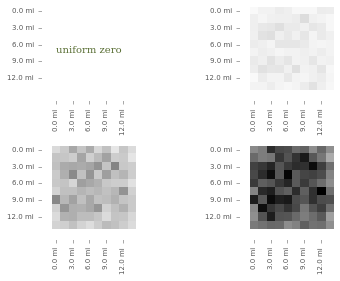

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2)
#fig.subplots_adjust(bottom=0.5)


for i in range(4):
    lines = []

#    cmap_custom = cm.get_cmap('YlGn')
    cmap_custom = cm.get_cmap('Greys')
    #cmap_custom = new_cmap

    #image = np.random.uniform(size=(10, 10))
    axes[i/2, i%2].imshow(raw_data_per_tick[i], cmap=cmap_custom, interpolation='nearest', vmin=0, vmax=max_installs)

    #ax.set_title('Number of installations \n in a neighborhood')

    # Move left and bottom spines outward by 10 points
    axes[i/2, i%2].spines['left'].set_position(('outward', 10))
    axes[i/2, i%2].spines['bottom'].set_position(('outward', 10))
    # Hide the right and top spines
    axes[i/2, i%2].spines['right'].set_visible(False)
    axes[i/2, i%2].spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    axes[i/2, i%2].yaxis.set_ticks_position('left')
    axes[i/2, i%2].xaxis.set_ticks_position('bottom')
    
    for tick in axes[i/2, i%2].get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize('x-small')
        
    for tick in axes[i/2, i%2].get_yticklabels():
        tick.set_fontsize('x-small')

    labels_ = ['mi']
    xs = range(10)

    from matplotlib.ticker import FuncFormatter, MaxNLocator
    def format_fn(tick_val, tick_pos):
        if int(tick_val) in xs:
            return str(tick_val * 1.5) + ' ' + labels_[0]
        else:
            return ''


    axes[i/2, i%2].xaxis.set_major_formatter(FuncFormatter(format_fn))
    axes[i/2, i%2].yaxis.set_major_formatter(FuncFormatter(format_fn))

    axes[i/2, i%2].grid(False)




#    handles, labels = ax.get_legend_handles_labels()

    # Put a legend below current axis
    #lgd = ax.legend(handles, ['test'], loc='lower center', bbox_to_anchor=(0.5, -0.25),\
    #          fancybox=True, shadow=True, fontsize='10', ncol = 2)

    
#add comment to the first plot
font = {'family': 'serif',
        'color':  'darkolivegreen',
        'weight': 'normal',
        'size': 10,
        }
axes[0,0].text(0.0, 5.0, 'uniform zero', fontdict=font)
    

plt.tight_layout()
data_mode = 'test'
plt.savefig('Simulation_results_spatial_' + data_mode + '_Mar14' + '.png', dpi=300)

plt.show()

In [21]:
#redo bubbles figure

In [123]:
dfs_agg_inst = []
for df_ in dfs_inst:

    df_['Count'] = 1
    grouped = df_.groupby('Uid', sort=False)
    df_agg = grouped.agg({'Price_per_watt' : np.median,\
             'DC_size' : np.median, \
            'Count' : np.sum})
    dfs_agg_inst.append(df_agg)
    
df_inst_all = pd.concat(dfs_agg_inst)
df_inst_mean = df_agg.groupby(level=0).mean()

In [124]:
df_inst_all.head(20)

,Count,DC_size,Price_per_watt
Uid,,,
54,28,4533.330,2.51430
57,24,5175.890,2.61782
55,77,4768.280,2.48746
40,55,4399.600,2.59964
52,26,5362.005,2.63676
42,33,5499.490,2.60233
56,16,5226.090,2.51463
48,43,4160.680,2.60184
53,16,4140.710,2.52148


In [107]:
df_inst_mean.head(20)

,Count,DC_size,Price_per_watt
Uid,,,
40,41,4399.600,2.595290
41,50,5200.380,2.593990
42,64,5520.950,2.502640
43,36,4760.080,2.593150
44,50,5040.090,2.601570
45,22,5348.420,2.461145
46,55,4501.090,2.600780
47,37,4238.470,2.479600
48,65,4680.760,2.592880


In [108]:
#sort by count?
df_inst_mean = df_inst_mean.sort_values('Count', ascending=False)

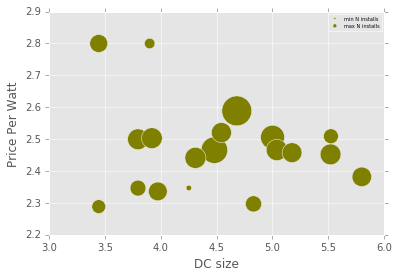

In [29]:
N = 19





x = df_inst_mean['DC_size']/1000
y = df_inst_mean['Price_per_watt']
norm = matplotlib.colors.Normalize(vmin=df_inst_mean['Count'].values[N-1], vmax=df_inst_mean['Count'].values[0])
cmap_custom = cm.get_cmap('Spectral')
area = norm(df_inst_mean['Count'])
color = []

for area_x in area:
#    color.append(cmap_custom(area_x/2))
    color.append('olive')
    

    
#color[1] = (0.0, 0.65, 0.75, 1.0)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('DC size')
ax.set_ylabel('Price Per Watt')

#ax.set_autoscaley_on(False)
#ax.set_xlim([0,0.2])
#ax.set_ylim([0,5])
    
#plt.xlabel('Price Per Watt')
#plt.ylabel('System Size AC')
#plt.title('Number of Installations Per Company')

ax.scatter(x, y, s=df_inst_mean['Count'] * 10,  c = color )
handles, labels = ax.get_legend_handles_labels()


#names are here
#df_agg.index.values[0:3]

#colors are here
#color[0:3]

artists = []
labels = []

#create custom artists
#for i in range(3):
#    artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[i]))
#    labels.append(df_agg_dm1.index.values[i])

artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[-1], label='min'))
labels.append('min N installs')
artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[0], label='max'))
labels.append('max N installs')
    

class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
#        print(orig_handle.__dict__)
        radius_ = width/10
        if ('max' in orig_handle._label):
            radius_ = width/5
    
        p = mpatches.Circle(xy=center, radius=radius_)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    

#Create legend from custom artist/label lists
ax.legend(artists,
          labels,
         handler_map={mpatches.Circle: HandlerEllipse()}, bbox_to_anchor=(0.9, 0.9),
           bbox_transform=plt.gcf().transFigure, fontsize=5
         )



#plt.scatter(x, y, s=df_agg_top['Count'],  c = color )
data_mode = 'test'
plt.savefig('Simulation_results_installers_' + data_mode + '_Mar18' + '.png', dpi=300)
plt.show()

In [125]:
#sort by count?
df_inst_all = df_inst_all.sort_values('Count', ascending=False)

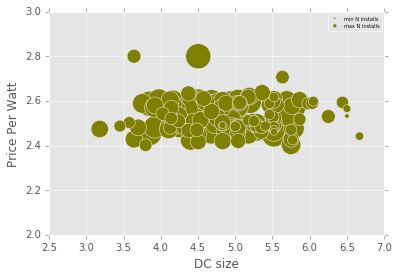

In [126]:
N = 19





x = df_inst_all['DC_size']/1000
y = df_inst_all['Price_per_watt']
norm = matplotlib.colors.Normalize(vmin=df_inst_all['Count'].values[N-1], vmax=df_inst_all['Count'].values[0])
cmap_custom = cm.get_cmap('Spectral')
area = norm(df_inst_all['Count'])
color = []

for area_x in area:
#    color.append(cmap_custom(area_x/2))
    color.append('olive')
    

    
#color[1] = (0.0, 0.65, 0.75, 1.0)
    
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('DC size')
ax.set_ylabel('Price Per Watt')

#ax.set_autoscaley_on(False)
ax.set_xlim([2.5,7.0])
ax.set_ylim([2.0,3.0])
    
#plt.xlabel('Price Per Watt')
#plt.ylabel('System Size AC')
#plt.title('Number of Installations Per Company')

ax.scatter(x, y, s=df_inst_all['Count'] * 10,  c = color )
handles, labels = ax.get_legend_handles_labels()


#names are here
#df_agg.index.values[0:3]

#colors are here
#color[0:3]

artists = []
labels = []

#create custom artists
#for i in range(3):
#    artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[i]))
#    labels.append(df_agg_dm1.index.values[i])

artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[-1], label='min'))
labels.append('min N installs')
artists.append(mpatches.Circle((0, 0), 1.0, facecolor=color[0], label='max'))
labels.append('max N installs')
    

class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
#        print(orig_handle.__dict__)
        radius_ = width/10
        if ('max' in orig_handle._label):
            radius_ = width/5
    
        p = mpatches.Circle(xy=center, radius=radius_)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    

#Create legend from custom artist/label lists
ax.legend(artists,
          labels,
         handler_map={mpatches.Circle: HandlerEllipse()}, bbox_to_anchor=(0.9, 0.9),
           bbox_transform=plt.gcf().transFigure, fontsize=5
         )



#plt.scatter(x, y, s=df_agg_top['Count'],  c = color )
data_mode = 'test'
plt.savefig('Simulation_results_installers_' + data_mode + '_Apr18_2' + '.png', dpi=300)
plt.show()

# Testing random code

In [ ]:
#how to see what is inside an object
print(mpatches.Circle((0, 0), 5.0, facecolor=color[0]).__dict__)

In [38]:
#sticky prices
y_start = 0.2
y_target = 0.5
theta_learn = 0.99
y_prog_ = [y_start]
x_tick_ = []
for i in range(200):
    y_prog_.append(y_prog_[-1] * theta_learn + y_target * (1 - theta_learn))
    x_tick_.append(i)

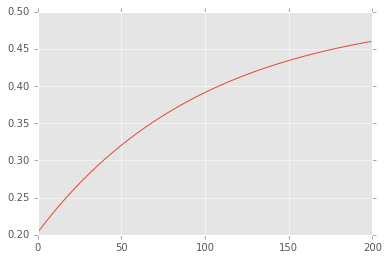

In [58]:
plt.plot(x_tick_, y_prog_[1:])

In [35]:
prices  = dfs_w[0]['P_av']

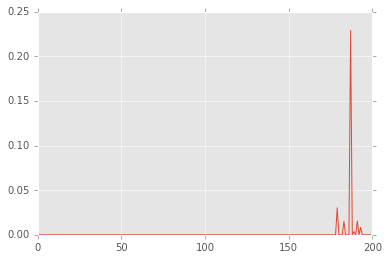

In [39]:
plt.plot(x_tick_, prices[0:200])

In [45]:
dfs_inst[0].head()

,Tick,Location_x,Location_y,Uid,Price_per_watt,DC_size
0,29,9,8,48,4.34654,5199.74
1,43,4,6,48,5.33618,4501.09
2,37,4,4,46,3.47883,9002.18
3,65,7,3,48,4.61828,5251.27
4,147,1,3,40,5.29697,4140.71


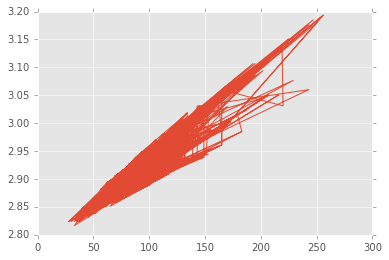

In [66]:
plt.plot(dfs_inst[0]['Tick'], dfs_inst[0]['Price_per_watt'])

In [20]:
test_mode = 'BaseModel'
test_version = 'BaseVer01'
test_loc = 'CA'
data_mode = 'Logs'
version = '_eff'
params_versions = [str(x) for x in np.linspace(1.0,1.5,1,endpoint=False)]
i_run = 0

In [33]:
files = glob.glob('..\\..\\ABMIRISLab\\Saves\\Oct-18-2017\\' + test_mode + '\\' + test_version + '\\'  +\
                          test_loc + '\\' + params_versions[i_run] + '\\' + data_mode +\
                         '\\*[_log].log')
files.sort(key=os.path.getmtime, reverse=True)
        #files_ = files[i_run * N_SEEDS : (i_run + 1) * N_SEEDS]    

In [34]:
len(files)

50

In [6]:
df_test = pd.DataFrame([[0,1],[0.1, 0.15], [0.9, 0.85], [200, 205]]).T

In [7]:
df_test.head()

,0,1,2,3
0,0.0,0.10,0.90,200.0
1,1.0,0.15,0.85,205.0


Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')
Text(0,0,'')


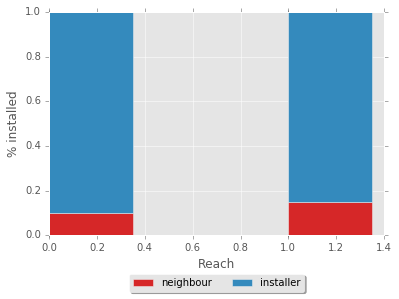

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Reach')
ax.set_ylabel('% installed')
lines = []
N = 2

ind = np.arange(N)
width = 0.35


p1 = plt.bar(ind, df_test[1], width, color='#d62728', label='neighbour')
p2 = plt.bar(ind, df_test[2], width,
             bottom=df_test[1], label='installer')

lines.append(p1)
lines.append(p2)


for tick in ax.get_xticklabels():
    print(tick)
    
ax.xaxis.set_ticks(ind, tuple([str(x) for x in ind]))

# Put a legend below current axis
lgd = ax.legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=True, shadow=True, fontsize='10', ncol = 2)


plt.show()

In [15]:
print(tuple([str(x) for x in ind]))

('0', '1')


In [83]:
dfs_w[i]['N_installed_sum'].ix[260]

634.625

In [84]:
dfs_w[3]['N_installed_sum'].ix[260]/dfs_w[0]['N_installed_sum'].ix[260]

0.84923180820530142

In [144]:
#location x, location y 


# for each line - place into location
# average over locations
#
#

N_TILES = 10
N_SEEDS = 8

test_mode = 'BaseVer02'
data_mode = 'CA'

#names of columns in a file
names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Mart_type']

raw_data_per_tick = []
raw_data_dfs_per_tick = []
tick_bins = []
for i in range(4):
    #to store final results
    raw_data_per_tick.append(np.zeros((N_TILES, N_TILES)))
    #to store intermediate results
    raw_data_dfs_per_tick.append(np.zeros((N_SEEDS, N_TILES, N_TILES)))
    #tick edges
    tick_bins.append(N_TICKS/4 *(i))


#here only baseline scenario is analyzed    
params_versions = [str(x) for x in np.linspace(0.0,0.3,N_TESTS,endpoint=False)]
    
#read few files
#save into database
dfs_ = []
#read last simulation result
files = glob.glob('..\\..\\ABMIRISLab\\Saves\\Jan-11-2018\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                 '\\tariff' + str(0.3) + '\\*[_pr].csv')
files.sort(key=os.path.getmtime, reverse=True)

#take top x files, assume only one type of a simulation run in a folder 
i_run = 0

for file in files[i_run * N_SEEDS : (i_run + 1) * N_SEEDS]:
    print(file)
    df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
    dfs_.append(df_)

    
raw_data_dfs = np.zeros((len(dfs_), N_TILES, N_TILES))

indexes = [0.0, 0.0, 0.0, 0.0]

k = 0
for df_ in dfs_:
    
    
    
    for i in range(N_TILES):
        for j in range(N_TILES):
            index = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j)].index 
                             
            indexes[0] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[0])].index
            
            indexes[1] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[1])].index
            
            indexes[2] = df_[(df_['Location_x'] == i) & \
                        (df_['Location_y'] == j) & \
                         (df_['Tick'] < tick_bins[2])].index
                             
            raw_data_dfs_per_tick[0][k, i, j] = df_.iloc[indexes[0]].shape[0]
            raw_data_dfs_per_tick[1][k, i, j] = df_.iloc[indexes[1]].shape[0]
            raw_data_dfs_per_tick[2][k, i, j] = df_.iloc[indexes[2]].shape[0]
            raw_data_dfs_per_tick[-1][k, i, j] = df_.iloc[index].shape[0]
            
    k = k + 1
    
    raw_data_per_tick[0] = np.mean(raw_data_dfs_per_tick[0], axis = 0)
    raw_data_per_tick[1] = np.mean(raw_data_dfs_per_tick[1], axis = 0)
    raw_data_per_tick[2] = np.mean(raw_data_dfs_per_tick[2], axis = 0)
    raw_data_per_tick[-1] = np.mean(raw_data_dfs_per_tick[-1], axis = 0)
    
    
#create df from them    
dfs_inst = dfs_

#blank first step
raw_data_per_tick[0] = np.zeros((N_TILES, N_TILES)) + 0.01

..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\e134031c-60bc-4586-8cd0-9abab6219a65_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\9a8d1051-c20f-426c-9654-8ac12fc86263_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\827986a4-67ca-4b04-8ea3-adff0b784dc0_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\442f886c-20c5-479e-8ecd-9956e011e9fd_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\d711f29d-3bd5-486b-acb1-e9422e8286f0_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\42561ea7-2046-407c-81f3-06b70777e17a_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\e7f3e9ee-edc2-4891-b0ad-8b81e8e933e6_pr.csv
..\..\ABMIRISLab\Saves\Jan-11-2018\BaseModel\BaseVer02\CA\tariff0.3\dfc53c5d-88f6-4a89-bdac-39da9c390e58_pr.csv


In [145]:
dfs_inst[0].head() 

,Tick,Location_x,Location_y,Uid,Price_per_watt,DC_size,Origin,Mart_type
0,36,7,2,45,2.80000,7426.55,Import,0
1,80,0,8,44,2.59459,3000.73,Domestic,0
2,34,9,8,57,2.80000,6440.73,Domestic,0
3,80,5,7,59,2.59194,7682.22,Import,0
4,32,3,7,58,2.80000,9076.90,Import,0


In [ ]:
dfs_agg_inst = []
for df_ in dfs_inst:

    df_['Count'] = 1
    grouped = df_.groupby('Uid', sort=False)
    df_agg = grouped.agg({'Price_per_watt' : np.median,\
             'DC_size' : np.median, \
            'Count' : np.sum})
    dfs_agg_inst.append(df_agg)
    
df_inst_all = pd.concat(dfs_agg_inst)
df_inst_mean = df_agg.groupby(level=0).mean()

In [92]:
N_SEEDS = 8

In [93]:
def collect_data_for_simulation_runs_from_inst(N_TESTS, dfs_inst, dfs_inst_std):

    test_mode = 'BaseVer02'
    data_mode = 'CA'
    #here think how to change it
    params_versions = [str(x) for x in np.linspace(0,100,N_TESTS,endpoint=True)]

    #names of columns in a file
    names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Efficency','EquipmentType', 'InteractionType','Mart_type']
    #names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Mart_type']


    for i_run in range(N_TESTS): 
        #read few files
        #save into database
        dfs_ = []
        #read last simulation result
        files = glob.glob('..\\..\\ABMIRISLab\\Saves\\May-14-2018\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                 '\\permit' + params_versions[i_run] + '\\*[_pr].csv')
        files.sort(key=os.path.getmtime, reverse=True)

        #take top x files 
        for file in files[0 * N_SEEDS : 1 * N_SEEDS]:
            print(file)
            df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
            df_['Total_price'] = df_['Price_per_watt'] * df_['DC_size']
            dfs_.append(df_)


        #create df from them    
        df_concat = pd.concat(dfs_)
        
        
        df_inst_mean = df_concat.groupby(level=0).mean()
        df_inst_std = df_concat.groupby(level=0).std()
        
        dfs_inst.append(dfs_)


In [94]:
dfs_inst = []
dfs_inst_std = []
collect_data_for_simulation_runs_from_inst(N_TESTS, dfs_inst, dfs_inst_std)

..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit0.0\3015c04e-154f-4efa-8439-df60b8648656_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit0.0\c346843b-a317-400f-951a-ca7047dfc09d_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit0.0\8bec746e-9c28-410d-b471-fff6e06b92ac_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit0.0\2f7ce004-5db8-49ac-b692-30d2e491a0d0_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit0.0\45997203-3e86-486b-bda7-42c14411abae_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit0.0\faea0d21-570a-410a-bd66-bb0bd0ecf16c_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit0.0\0c63b365-fdb7-46b1-88fd-00da0d81d3f9_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit0.0\2305873b-5348-43d0-b7e7-b73ce557bec0_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit25.0\e34f5bd5-44f6-49a0-b355-f78cf86ffac

In [95]:
print(len(dfs_inst))

5


In [96]:
dfs_agg_inst = []
df_inst_all = []
df_inst_mean = []

for i in range(len(dfs_inst)):
    for df_ in dfs_inst[i]:
#        print(df_)
        df_['Count'] = 1
        grouped = df_.groupby('Origin', sort=False)
        df_agg = grouped.agg({'Total_price' : np.sum,\
                 'DC_size' : np.sum, \
                'Count' : np.sum,
                             'Price_per_watt': np.average})
        dfs_agg_inst.append(df_agg)

    df_inst_all.append(pd.concat(dfs_agg_inst))
    df_inst_mean.append(df_agg.groupby(level=0).mean())

In [97]:
print(df_inst_mean)

[          Price_per_watt   Total_price  Count      DC_size
Origin                                                    
Domestic        2.409741  4.164252e+06    323  1728319.010
Import          2.526180  4.350602e+06    353  1722089.703,           Price_per_watt   Total_price  Count      DC_size
Origin                                                    
Domestic        2.453304  4.187991e+06    322  1708824.721
Import          2.465470  3.969088e+06    334  1607714.959,           Price_per_watt   Total_price  Count      DC_size
Origin                                                    
Domestic        2.513081  5.021955e+06    393  2005383.875
Import          2.490031  3.479552e+06    285  1395462.057,           Price_per_watt   Total_price  Count      DC_size
Origin                                                    
Domestic        2.462265  3.410649e+06    289  1385002.226
Import          2.446907  4.982953e+06    432  2035465.663,           Price_per_watt   Total_price  Count      

In [102]:
print(df_inst_all[-1])

          Price_per_watt   Total_price  Count      DC_size
Origin                                                    
Domestic        2.470964  6.222143e+06    466  2515395.511
Import          2.540913  3.926556e+06    306  1541103.003
Domestic        2.462569  5.621567e+06    453  2283386.905
Import          2.505407  3.678130e+06    304  1471981.359
Import          2.452380  4.585835e+06    390  1871867.518
Domestic        2.456961  3.189030e+06    250  1301577.746
Import          2.481973  2.349135e+06    194   946625.397
Domestic        2.512619  5.350074e+06    405  2133430.125
Domestic        2.475445  4.183945e+06    316  1689488.646
Import          2.484942  3.707353e+06    311  1487816.164
Import          2.508095  4.245818e+06    360  1690223.583
Domestic        2.479208  4.665917e+06    367  1883480.445
Import          2.516749  4.233081e+06    338  1681721.086
Domestic        2.482310  3.927345e+06    304  1581880.994
Import          2.526180  4.350602e+06    353  1722089.7

In [88]:
print(df_inst_all[0].at['Domestic', 'Count'])

[232 300 370 302 365 471 402 273 402 253 282 367 505 299 229 150 395 236]


In [99]:
a = df_inst_all[0].at['Domestic', 'Count'] + df_inst_all[0].at['Import', 'Count']

In [109]:
a = df_inst_all[0].at['Import', 'Price_per_watt']

In [100]:
b = df_inst_all[-1].at['Domestic', 'Count'] + df_inst_all[-1].at['Import', 'Count']

In [110]:
b = df_inst_all[-1].at['Import', 'Price_per_watt']

In [62]:
import scipy as sp
import scipy.stats

In [111]:
sp.stats.ks_2samp(a, b)

Ks_2sampResult(statistic=0.18910256410256404, pvalue=0.95126197268159907)

In [37]:
for i in range(len(df_inst_mean)):
    print(np.sum(df_inst_mean[i]['DC_size']))

3454539.813
3570106.433
3670514.41
3617376.618
3729870.291


In [38]:
for i in range(len(df_inst_mean)):
    print(np.sum(df_inst_mean[i]['Total_price']))

8562676.44322
8858786.94856
9157321.14351
8925637.80832
9283747.78357


In [39]:
for i in range(len(df_inst_mean)):
    print(np.sum(df_inst_mean[i]['Count']))

720
725
761
723
768


In [40]:
df_inst_mean[i].at['Domestic', 'Count']

405

In [41]:
data_columns = ['Domestic',\
                   'Foreign']
data_installs_origin = []
for i in range(N_TESTS):
    data_installs_origin.append([df_inst_mean[i].at['Domestic', 'Count'], \
                      df_inst_mean[i].at['Import', 'Count'],\
                                df_inst_mean[i].at['Domestic', 'Total_price'],\
                                df_inst_mean[i].at['Import', 'Total_price']])

In [42]:
print(data_installs_origin)

[[395, 325, 4680559.6738339327, 3882116.7693883488], [431, 294, 5297953.8044127962, 3560833.1441468392], [505, 256, 6130633.7133115949, 3026687.4301980417], [357, 366, 4475053.3926090728, 4450584.4157118713], [405, 363, 4947695.6967205359, 4336052.0868490888]]


In [43]:
data_installs_plot = np.array(data_installs_origin)


In [44]:
print(data_installs_plot.T)

[[  3.95000000e+02   4.31000000e+02   5.05000000e+02   3.57000000e+02
    4.05000000e+02]
 [  3.25000000e+02   2.94000000e+02   2.56000000e+02   3.66000000e+02
    3.63000000e+02]
 [  4.68055967e+06   5.29795380e+06   6.13063371e+06   4.47505339e+06
    4.94769570e+06]
 [  3.88211677e+06   3.56083314e+06   3.02668743e+06   4.45058442e+06
    4.33605209e+06]]


In [45]:
data_installs_plot.T[0][0:N_TESTS]

array([ 395.,  431.,  505.,  357.,  405.])

In [46]:
data_installs_plot.T[1][0:N_TESTS]

array([ 325.,  294.,  256.,  366.,  363.])

[ 325.  294.  256.  366.  363.]
[ 395.  431.  505.  357.  405.]


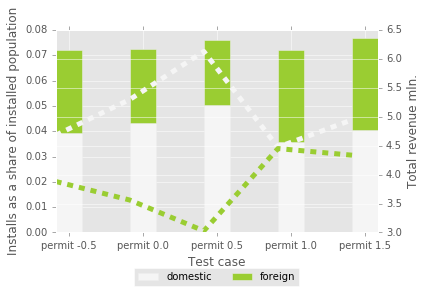

In [48]:
#number of dropouts as stacked bars
data_mode = 'permit_bm_'
test_mode = 'installs_origin'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#if ncols = 1  - transform into list
par1 = axes_.twinx()
axes = [axes_, par1]

ind = np.arange(len(dfs_logs))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


colors_drops = tuple(['whitesmoke', 'yellowgreen', 'coral'])

#N_TESTS = len(dfs_logs)
labels_raw = ['domestic', 'foreign']
labels_hist = ['' + x for x in labels_raw]

p1 = axes[0].bar(ind[0:N_TESTS], data_installs_plot.T[0][0:N_TESTS]/10000,\
                 width, color=colors_drops[0], label = labels_hist[0])
lines = [p1]



for bin_ in range(1, 2, 1):
    print(data_installs_plot.T[bin_][0:N_TESTS])
    print(data_installs_plot.T[bin_ - 1][0:N_TESTS])
    p2 = axes[0].bar(ind[0:N_TESTS], \
                     data_installs_plot.T[bin_][0:N_TESTS]/10000, \
                     width, color=colors_drops[bin_], \
                  bottom=data_installs_plot.T[bin_ - 1][0:N_TESTS]/10000, label = labels_hist[bin_])
    lines.append(p2)
    
axes[0].set_xlabel("Test case")
axes[0].set_ylabel("Installs as a share of installed population")
#axes[0].set_title('Accumulated % installations \n by the level \n of income', fontsize=10)


axes[0].set_xticks(ind[0:N_TESTS] + width / 2)
axes[0].set_xticklabels(ind[0:N_TESTS])
labels = ['permit ' + str(x) for x in np.linspace(-0.5,1.5,N_TESTS,endpoint=True)]
x_labels = labels
axes[0].set_xticklabels(x_labels)

# Put a legend below current axis
lgd = axes[0].legend(lines, [l.get_label() for l in lines], loc='upper center', bbox_to_anchor=(0.5, -0.15),\
          fancybox=False, shadow=False, fontsize='10', ncol = 2)


markers = ["o-", "--", "--", "--", "*-"]
markerfacecolors = colors_drops
colors_l = ['r', 'r', 'r']


#number of installs
pi, = axes[1].plot(ind, data_installs_plot.T[2][0:N_TESTS]/1000000, markers[1], linewidth=5,color = markerfacecolors[0])
pi, = axes[1].plot(ind, data_installs_plot.T[3][0:N_TESTS]/1000000, markers[1], linewidth=5,color = markerfacecolors[1])

axes[1].set_ylabel("Total revenue mln.")


plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_May22' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
a = 

In [4]:
N_SEEDS = 8 
N_TESTS = 5

In [50]:
def collect_data_for_simulation_runs_from_inst(N_TESTS, dfs_inst, dfs_inst_std):

    test_mode = 'BaseVer02'
    data_mode = 'CA'
    #here think how to change it
    params_versions = [str(x) for x in np.linspace(-0.5,1.5,N_TESTS,endpoint=True)]
    params_versions.append(str(5.0))

    #names of columns in a file
    names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Efficency','EquipmentType', 'InteractionType','Mart_type']
    #names = ['Tick', 'Location_x', 'Location_y', 'Uid', 'Price_per_watt', 'DC_size', 'Origin', 'Mart_type']


    for i_run in range(N_TESTS + 1): 
        #read few files
        #save into database
        dfs_ = []
        #read last simulation result
        files = glob.glob('..\\..\\ABMIRISLab\\Saves\\May-14-2018\\BaseModel\\'+ test_mode + '\\' + data_mode + \
                 '\\permit' + params_versions[i_run] + '\\*[_pr].csv')
        files.sort(key=os.path.getmtime, reverse=True)

        #take top x files 
        for file in files[0 * N_SEEDS : 1 * N_SEEDS]:
            print(file)
            df_ = pd.read_csv(file, names=names, low_memory=False, na_values = ['-nan(ind)'])
            df_['Total_price'] = df_['Price_per_watt'] * df_['DC_size']
            dfs_.append(df_)


        #create df from them    
        df_concat = pd.concat(dfs_)
        
        
        df_inst_mean = df_concat.groupby(level=0).mean()
        df_inst_std = df_concat.groupby(level=0).std()
        
        dfs_inst.append(dfs_)

In [51]:
dfs_inst = []
dfs_inst_std = []
collect_data_for_simulation_runs_from_inst(N_TESTS, dfs_inst, dfs_inst_std)

..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit-0.5\f4fd1762-f088-4828-9914-955c7c971541_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit-0.5\ee9accb6-a6ea-48a1-9211-22186174e37c_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit-0.5\2064a9bc-4295-48f9-b1c7-e882b949239c_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit-0.5\db4c1f16-d9f9-4759-969d-16e1c95803a2_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit-0.5\00cb64c2-3a17-4ada-958b-d366e45b50dc_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit-0.5\aac7628f-cf19-46c1-a3f8-2ccd77a15ebc_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit-0.5\89fc31a8-6b4a-484c-b4da-07c170c81609_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit-0.5\71519c82-3716-43ae-b372-8319e9b2b5f5_pr.csv
..\..\ABMIRISLab\Saves\May-14-2018\BaseModel\BaseVer02\CA\permit0.0\cc6d5c3c-668d-46cc-a23c-0cb6

In [9]:
a = df_inst_all[0].at['Domestic', 'Count'] + df_inst_all[0].at['Import', 'Count']

In [52]:
dfs_agg_inst = []
df_inst_all = []
df_inst_mean = []

for i in range(len(dfs_inst)):
    for df_ in dfs_inst[i]:
#        print(df_)
        df_['Count'] = 1
        grouped = df_.groupby('Origin', sort=False)
        df_agg = grouped.agg({'Total_price' : np.sum,\
                 'DC_size' : np.sum, \
                'Count' : np.sum,
                             'Price_per_watt': np.average})
        dfs_agg_inst.append(df_agg)

    df_inst_all.append(pd.concat(dfs_agg_inst))
    df_inst_mean.append(df_agg.groupby(level=0).mean())

In [53]:
print(len(dfs_inst))

6


In [54]:
for df_ in df_inst_all:
    print(df_.at['Domestic', 'Count'] + df_.at['Import', 'Count'])

[2005 1684 1801 1832 1855 1888 1865 1621]
[2005 1684 1801 1832 1855 1888 1865 1621 1763 1657 2011 1909 2074 2076 1883
 1755]
[2005 1684 1801 1832 1855 1888 1865 1621 1763 1657 2011 1909 2074 2076 1883
 1755 1879 1762 1712 1807 1735 1900 1907 1691]
[2005 1684 1801 1832 1855 1888 1865 1621 1763 1657 2011 1909 2074 2076 1883
 1755 1879 1762 1712 1807 1735 1900 1907 1691 1672 1655 1955 1817 1698 1552
 2059 1856]
[2005 1684 1801 1832 1855 1888 1865 1621 1763 1657 2011 1909 2074 2076 1883
 1755 1879 1762 1712 1807 1735 1900 1907 1691 1672 1655 1955 1817 1698 1552
 2059 1856 1793 1872 1886 1936 1651 1798 1652 1898]
[2005 1684 1801 1832 1855 1888 1865 1621 1763 1657 2011 1909 2074 2076 1883
 1755 1879 1762 1712 1807 1735 1900 1907 1691 1672 1655 1955 1817 1698 1552
 2059 1856 1793 1872 1886 1936 1651 1798 1652 1898 1605 1446 1906 1573 1362
 1170 1289 1476]


In [55]:
data = np.zeros((8,6))
for i in range(N_TESTS +1):
    data[:,i]=df_inst_all[-1].at['Domestic', 'Count'][i*N_SEEDS:(i+1)*N_SEEDS] + df_inst_all[-1].at['Import', 'Count'][i*N_SEEDS:(i+1)*N_SEEDS]

NameError: name 'lgd' is not defined

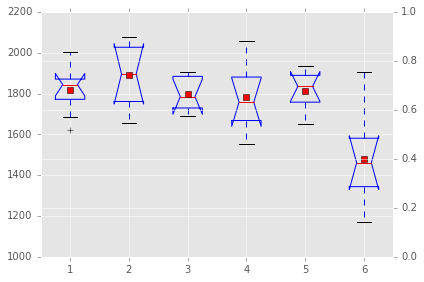

In [56]:
#number of dropouts as stacked bars
data_mode = 'permit_bm_'
test_mode = 'installs_origin'
fig, axes_ = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(bottom=0.25)

#if ncols = 1  - transform into list
par1 = axes_.twinx()
axes = [axes_, par1]


axes[0].boxplot(data, list('ABCDE'), showmeans=True, showbox=True)


plt.tight_layout()
plt.savefig('Simulation_results_' + data_mode + test_mode + '_Jul29' + '.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [49]:
print(data)

[[ 2005.  1763.  1879.  1672.  1793.     0.]
 [ 1684.  1657.  1762.  1655.  1872.     0.]
 [ 1801.  2011.  1712.  1955.  1886.     0.]
 [ 1832.  1909.  1807.  1817.  1936.     0.]
 [ 1855.  2074.  1735.  1698.  1651.     0.]
 [ 1888.  2076.  1900.  1552.  1798.     0.]
 [ 1865.  1883.  1907.  2059.  1652.     0.]
 [ 1621.  1755.  1691.  1856.  1898.     0.]]
